## 설정

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터셋 다운로드 및 탐색

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```
- 5가지 클래스로 구성 돼 있다.

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir) / "flower_photos"

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### 첫 번째 장미 데이터 시각화

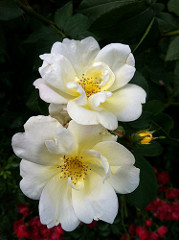

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### 첫 번째 튤립 데이터 시각화

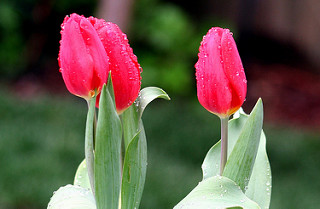

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

## 데이터셋 만들기

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


- 이미지의 ``80%`` 는 **훈련**, ``20%`` 는 **검증** 에 사용한다.

### 클래스 명 출력

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화

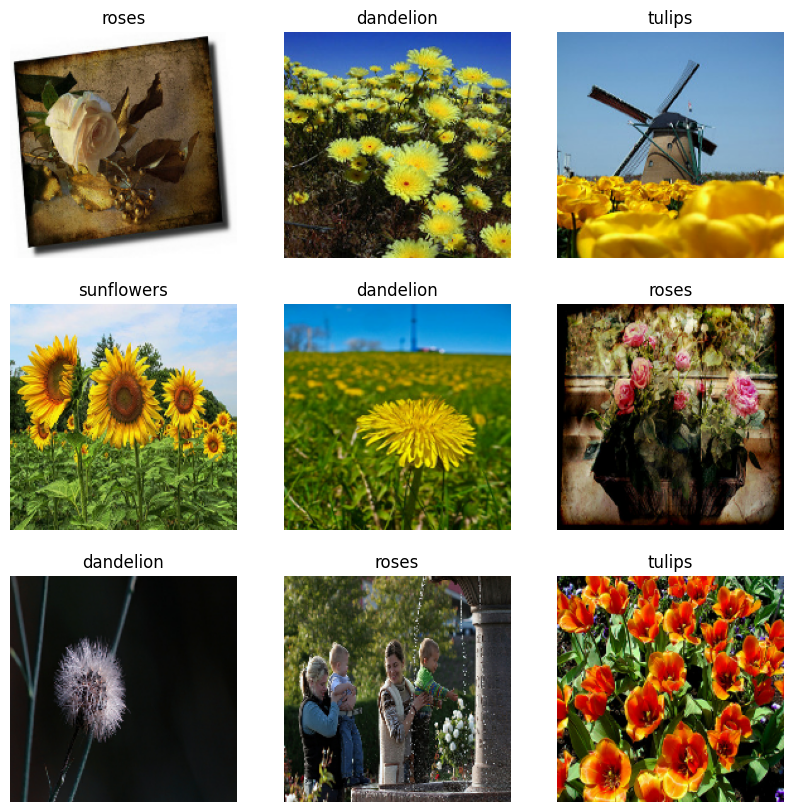

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 성능을 높이도록 데이터셋 구성하기

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 데이터 정규화

In [12]:
normalization_layer = layers.Rescaling(1./255)

- ``Dataset.map`` 을 사용해서 이 레이어를 데이터셋에 적용할 수 있다.
- ``normalization_layer`` 가 ``Rescaling``의 **인스턴스**가 되며, ``__call__`` 메소드가 구현돼 있어 **함수** 처럼 사용이 가능하다.

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0092984075 1.0


- **정규화** 가 됐는지 확인

## 기본 Keras 모델

### 모델 만들기

In [17]:
num_classes = len(class_names)

model = Sequential([
  keras.Input(shape=(img_height, img_width, 3)),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 모델 컴파일하기

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### 모델 훈련하기

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.3252 - loss: 1.7560 - val_accuracy: 0.5722 - val_loss: 1.0906
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5778 - loss: 1.0383 - val_accuracy: 0.6226 - val_loss: 0.9753
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.6845 - loss: 0.8231 - val_accuracy: 0.6226 - val_loss: 0.9164
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.7943 - loss: 0.5881 - val_accuracy: 0.6444 - val_loss: 1.0261
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.8764 - loss: 0.3668 - val_accuracy: 0.6185 - val_loss: 1.2222
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.9361 - loss: 0.2133 - val_accuracy: 0.6580 - val_loss: 1.2489
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9682 - loss: 0.1134 - val_accuracy: 0.6294 - val_loss: 1.6729
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9739 - loss: 0.0923 - val_accuracy: 0.6444 - v

### 훈련 결과 시각화

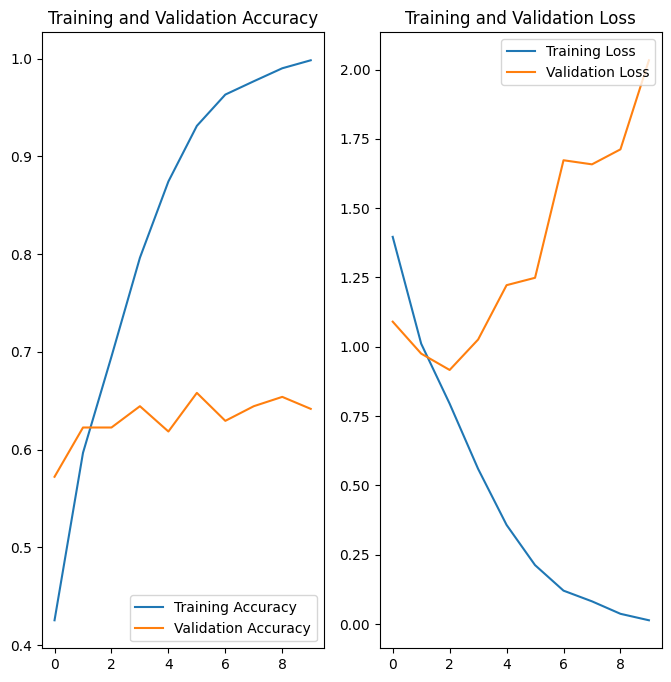

Total Epochs: 10

 최종 - Accuracy: 0.9983, Validation Accuracy: 0.6417
 최종 - Loss: 0.0134, Validation Loss: 2.0335



In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print(f"Total Epochs: {len(acc)}\n")
print(f" 최종 - Accuracy: {acc[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")
print(f" 최종 - Loss: {loss[-1]:.4f}, Validation Loss: {val_loss[-1]:.4f}\n")

## 과대적합(과적합)
- **모델** 이 ``훈련 데이터`` 에 대해서는 거의 완벽하게 맞췄지만, ``검증 데이터`` 에 대해서는 ``64%`` 정도로 성능이 뚝 떨어졌다.
- 이는 **모델** 이 ``훈련 데이터`` 를 **암기하듯 외운 상태** 로 새로운 데이터를 **일반화 하지 못한거다.**
- 이런 ``과대적합(과적합)`` 문제를 해결하기위해 이 챕터에서는 ``데이터 증강`` , ``모델에 드롭아웃을 추가`` 한다.